In [1]:
# Set up packages for lecture. Don't worry about understanding this code, but
# make sure to run it if you're following along.
import numpy as np
import babypandas as bpd
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
from scipy import stats
set_matplotlib_formats("svg")
plt.style.use('ggplot')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

from ipywidgets import widgets
from IPython.display import clear_output, display

# New minimize function (wrapper around scipy.optimize.minimize)
from inspect import signature
from scipy import optimize

def minimize(function):
    n_args = len(signature(function).parameters)
    initial = np.zeros(n_args)
    return optimize.minimize(lambda x: function(*x), initial).x

# All of the following code is for visualization.
def plot_regression_line(df, x, y, margin=.02):
    '''Computes the slope and intercept of the regression line between columns x and y in df (in original units) and plots it.'''
    m = slope(df, x, y)
    b = intercept(df, x, y)
    
    df.plot(kind='scatter', x=x, y=y, s=100, figsize=(10, 5), label='original data')
    left = df.get(x).min()*(1 - margin)
    right = df.get(x).max()*(1 + margin)
    domain = np.linspace(left, right, 10)
    plt.plot(domain, m*domain + b, color='orange', label='regression line', lw=4)
    plt.suptitle(format_equation(m, b), fontsize=18)
    plt.legend();
    
def format_equation(m, b):
    if b > 0:
        return r'$y = %.2fx + %.2f$' % (m, b)
    elif b == 0:
        return r'$y = %.2fx' % m
    else:
        return r'$y = %.2fx %.2f$' % (m, b)
    
def plot_errors(df, m, b, ax=None):
    x = df.get('x')
    y = m * x + b
    df.plot(kind='scatter', x='x', y='y', s=100, label='original data', ax=ax, figsize=(10, 5) if ax is None else None)
    
    if ax:
        plotter = ax
    else:
        plotter = plt
    
    plotter.plot(x, y, color='orange', lw=4)
    
    for k in np.arange(df.shape[0]):
        xk = df.get('x').iloc[k]
        yk = np.asarray(y)[k]
        if k == df.shape[0] - 1:
            plotter.plot([xk, xk], [yk, df.get('y').iloc[k]], linestyle=(0, (1, 1)), c='r', lw=4, label='errors')
        else:
            plotter.plot([xk, xk], [yk, df.get('y').iloc[k]], linestyle=(0, (1, 1)), c='r', lw=4)
    
    plt.title(format_equation(m, b), fontsize=18)
    plt.xlim(50, 90)
    plt.ylim(40, 100)
    plt.legend();

# Lecture 25 – Regression and Least Squares

## DSC 10, Fall 2022

### Announcements

- Lab 8 is due on **Saturday 11/26 at 11:59pm**.
- The Final Project is due on **Tuesday 11/29 at 11:59pm**.
- No class or office hours on Thursday or Friday. Happy Thanksgiving! 🦃
- There are several study sessions/group office hours in Week 10, which should be helpful as you complete the final project and study for the final exam. These are marked in green on the [calendar](https://dsc10.com/calendar).
    - Monday 11/28 from 12-2pm in PCNYH 122.
    - Tuesday 11/29 from 7-9pm in SDSC Auditorium (with no heat 🥶; dress warmly 🧣).
    - Wednesday 11/30 from 3-7pm in SDSC Auditorium (with no heat 🥶; dress warmly 🧣).
    - Friday 12/2 from 5-9pm in WLH 2205.
- Lecture section C00 is not meeting today or Monday 11/28 – Suraj is in India 🇮🇳. 

### Agenda

- The regression line, in standard units.
- The regression line, in original units.
- Outliers.
- Errors in prediction.

## The regression line, in standard units

### Example: Predicting heights  👪 📏

Recall, in the last lecture, we aimed to use a mother's height to predict her adult son's height.

In [2]:
galton = bpd.read_csv('data/galton.csv')
male_children = galton[galton.get('gender') == 'male']
mom_son = bpd.DataFrame().assign(mom = male_children.get('mother'), 
                                 son = male_children.get('childHeight'))
mom_son

,mom,son
0,67.0,73.2
4,66.5,73.5
5,66.5,72.5
...,...,...
925,60.0,66.0
929,66.0,64.0
932,63.0,66.5


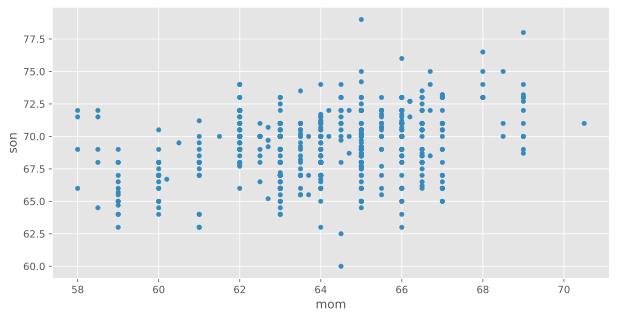

In [3]:
mom_son.plot(kind='scatter', x='mom', y='son', figsize=(10, 5));

### Correlation

Recall, the correlation coefficient $r$ of two variables $x$ and $y$ is defined as the 
- **average** value of the 
- **product** of $x$ and $y$
- when both are measured in **standard units**.

In [4]:
def standard_units(any_numbers):
    "Convert a sequence of numbers to standard units."
    return (any_numbers - any_numbers.mean()) / np.std(any_numbers)

def correlation(df, x, y):
    "Computes the correlation between column x and column y of df."
    return (standard_units(df.get(x)) * standard_units(df.get(y))).mean()

In [5]:
r_mom_son = correlation(mom_son, 'mom', 'son')
r_mom_son

0.32300498368490554

### The regression line

- The regression line is the line through $(0,0)$ with slope $r$, when both variables are measured in **standard units**.

<center><img src='data/regression-line.png' width=30%></center>

- We use the regression line to make predictions!

### Making predictions in standard units

<center><img src='data/regression-line.png' width=30%></center>

- If $r = 0.32$, and the given $x$ is $2$ in standard units, then the prediction for $y$ is $0.64$ standard units.
    - The regression line predicts that a mother whose height is $2$ SDs above average has a son whose height is $0.64$ SDs above average.

- We always _predict_ that a son will be somewhat **closer to average** in height than his mother.
    - This is a consequence of the slope $r$ having magnitude less than 1.
    - This effect is called **regression to the mean**.

- The regression line passes through the origin $(0, 0)$ in standard units. This means that, no matter what $r$ is, **for an average $x$ value, we predict an average $y$ value**.

### Making predictions in original units

Of course, we'd like to be able to predict a son's height in inches, not just in standard units. Given a mother's height in inches, here's how we'll predict her son's height in inches:
1. Convert the mother's height from inches to standard units.

$$x_{i \: \text{(su)}} = \frac{x_i - \text{mean of $x$}}{\text{SD of $x$}}$$

2. Multiply by the correlation coefficient to predict the son's height in standard units.

$$\text{predicted } y_{i \: \text{(su)}} = r \cdot x_{i \: \text{(su)}}$$

3. Convert the son's predicted height from standard units back to inches.

$$\text{predicted } y_i = \text{predicted } y_{i \: \text{(su)}} \cdot \text{SD of $y$} + \text{mean of $y$}$$

In [6]:
mom_mean = mom_son.get('mom').mean()
mom_sd = np.std(mom_son.get('mom'))
son_mean = mom_son.get('son').mean()
son_sd = np.std(mom_son.get('son'))

In [7]:
def predict_with_r(mom):
    """Return a prediction for the height of a son whose mother has height mom, 
    using linear regression.
    """
    mom_su = (mom - mom_mean) / mom_sd
    son_su = r_mom_son * mom_su
    return son_su * son_sd + son_mean

In [8]:
predict_with_r(68)

70.68219686848828

In [9]:
predict_with_r(60)

67.76170758654767

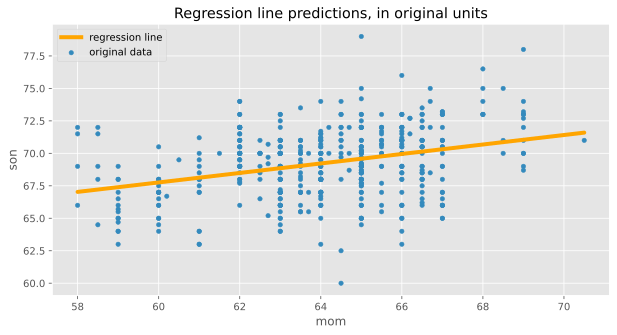

In [10]:
preds = mom_son.assign(
    predicted_height=mom_son.get('mom').apply(predict_with_r)
)
ax = preds.plot(kind='scatter', x='mom', y='son', title='Regression line predictions, in original units', figsize=(10, 5), label='original data')
preds.plot(kind='line', x='mom', y='predicted_height', ax=ax, color='orange', label='regression line', lw=4);
plt.legend();

### Concept Check ✅ – Answer at [cc.dsc10.com](http://cc.dsc10.com) 

A course has a midterm (mean 80, standard deviation 15) and a really hard final (mean 50, standard deviation 12).

If the scatter plot comparing midterm & final scores for students looks linearly associated with correlation 0.75, then what is the predicted final exam score for a student who received a 90 on the midterm?

- A. 54
- B. 56
- C. 58
- D. 60
- E. 62

## The regression line, in original units

### Reflection

Each time we wanted to predict the height of an adult son given the height of a mother, we had to:

1. Convert the mother's height from inches to standard units.


2. Multiply by the correlation coefficient to predict the son's height in standard units.

3. Convert the son's predicted height from standard units back to inches.


This is inconvenient – wouldn't it be great if we could express the regression line itself in inches?

### From standard units to original units

When $x$ and $y$ are in standard units, the regression line is given by

<center><img src='data/regression-line.png' width=30%></center>

What is the regression line when $x$ and $y$ are in their original units?

<center><img src="data/original_standard.png" width=50%></center>

### The regression line in original units

- We can work backwards from the relationship 
$$\text{predicted } y_{\text{(su)}} = r \cdot x_{\text{(su)}}$$
to find the line in original units.

$$\frac{\text{predicted } y - \text{mean of }y}{\text{SD of }y} = r \cdot \frac{x - \text{mean of } x}{\text{SD of }x}$$

- Note that $r, \text{mean of } x$, $\text{mean of } y$, $\text{SD of } x$, and $\text{SD of } y$ are constants – if you have a DataFrame with two columns, you can determine all 5 values.
- Re-arranging the above equation into the form $\text{predicted } y = mx + b$ yields the formulas:

$$m = r \cdot \frac{\text{SD of } y}{\text{SD of }x}, \: \: b = \text{mean of } y - m \cdot \text{mean of } x$$

- $m$ is the slope of the regression line and $b$ is the intercept.

Let's implement these formulas in code and try them out.

In [11]:
def slope(df, x, y):
    "Returns the slope of the regression line between columns x and y in df (in original units)."
    r = correlation(df, x, y)
    return r * np.std(df.get(y)) / np.std(df.get(x))

def intercept(df, x, y):
    "Returns the intercept of the regression line between columns x and y in df (in original units)."
    return df.get(y).mean() - slope(df, x, y) * df.get(x).mean()

Below, we compute the slope and intercept of the regression line between mothers' heights and sons' heights (in inches).

In [12]:
m_heights = slope(mom_son, 'mom', 'son')
m_heights

0.36506116024257595

In [13]:
b_heights = intercept(mom_son, 'mom', 'son')
b_heights

45.85803797199311

So, the regression line is

$$\text{predicted son's height} = 0.365 \cdot \text{mother's height} + 45.858$$

### Making predictions

In [14]:
def predict_son(mom):
    return m_heights * mom + b_heights

What's the predicted height of a son whose mother is 62 inches tall?

In [15]:
predict_son(62)

68.49182990703282

What if the mother is 55 inches tall? 73 inches tall?

In [16]:
predict_son(55)

65.9364017853348

In [17]:
predict_son(73)

72.50750266970115

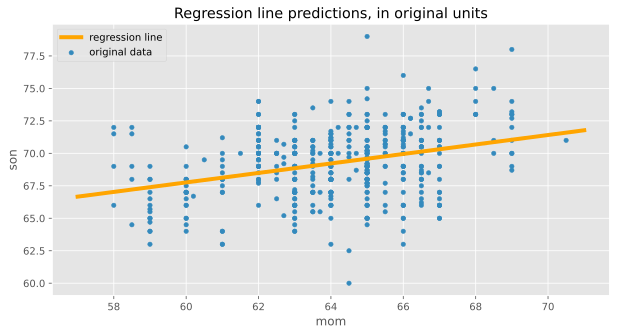

In [18]:
xs = np.arange(57, 72)
ys = predict_son(xs)
mom_son.plot(kind='scatter', x='mom', y='son', figsize=(10, 5), title='Regression line predictions, in original units', label='original data');
plt.plot(xs, ys, color='orange', lw=4, label='regression line')
plt.legend();

## Outliers

### The effect of outliers on correlation

Consider the dataset below. What is the correlation between $x$ and $y$?

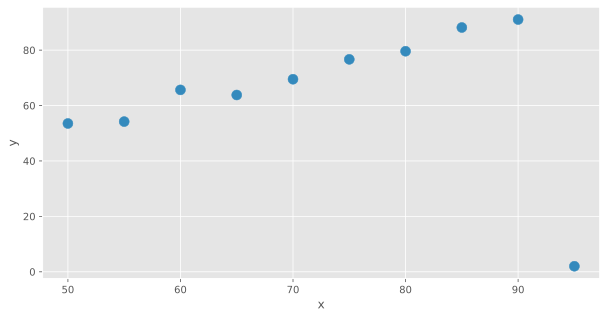

In [19]:
outlier = bpd.read_csv('data/outlier.csv')
outlier.plot(kind='scatter', x='x', y='y', s=100, figsize=(10, 5));

In [20]:
correlation(outlier, 'x', 'y')

-0.02793982443854457

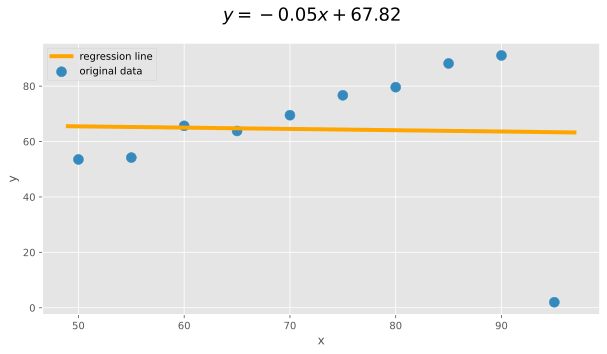

In [21]:
plot_regression_line(outlier, 'x', 'y')

### Removing the outlier

In [22]:
without_outlier = outlier[outlier.get('y') > 40]

In [23]:
correlation(without_outlier, 'x', 'y')

0.9851437295364016

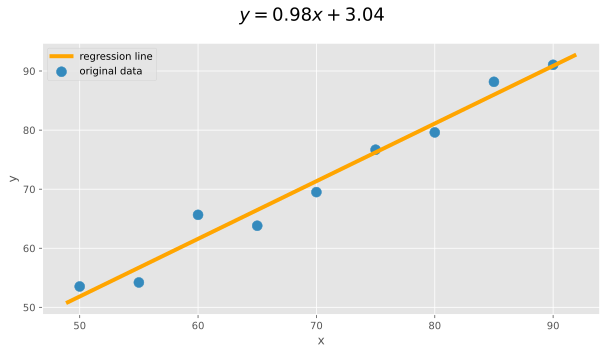

In [24]:
plot_regression_line(without_outlier, 'x', 'y')

**Takeaway**: Even a single outlier can have a massive impact on the correlation, and hence the regression line. Look for these before performing regression. **Always visualize first!**

## Errors in prediction

### Motivation

- We've presented the regression line in standard units as the line through the origin with slope $r$, given by $\text{predicted } y_{\text{(su)}} = r \cdot x_{\text{(su)}}$. Then, we used this equation to find a formula for the regression line in original units.

- In examples we've seen so far, the regression line seems to fit our data pretty well.
    - But how well? 
    - What makes the regression line good?
    - Would another line be better?

### Example: Without the outlier

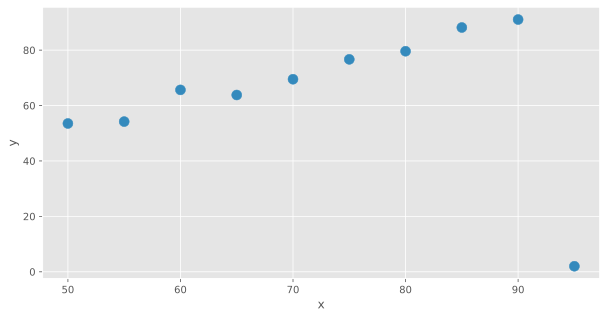

In [25]:
outlier.plot(kind='scatter', x='x', y='y', s=100, figsize=(10, 5));

In [26]:
m_no_outlier = slope(without_outlier, 'x', 'y')
b_no_outlier = intercept(without_outlier, 'x', 'y')

m_no_outlier, b_no_outlier

(0.975927715724588, 3.042337135297444)

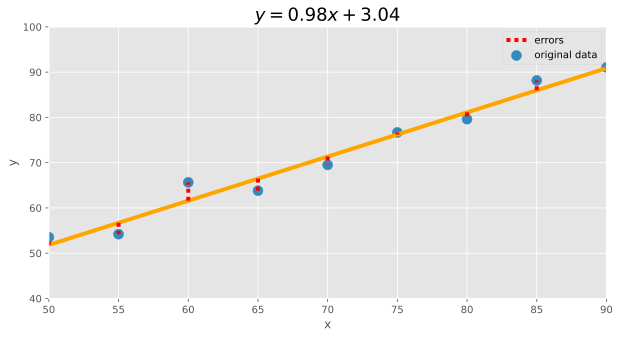

In [27]:
plot_errors(without_outlier, m_no_outlier, b_no_outlier)

We think our regression line is pretty good because most data points are pretty close to the regression line. The red lines are quite short.

### Measuring the error in prediction

$$\text{error} = \text{actual value} - \text{prediction}$$

- Typically, some errors are positive and some negative.
    - What does a positive error mean? What about a negative error?

- To measure the rough size of the errors, for a particular set of predictions:
    1. Square the errors so that they don't cancel each other out.
    2. Take the mean of the squared errors.
    3. Take the square root to fix the units.

- This is called **root mean square error** (RMSE).
    - Notice the similarities to computing the SD!

### Root mean squared error (RMSE) of the regression line's predictions

In [28]:
predictions = without_outlier.assign(pred=m_no_outlier * without_outlier.get('x') + b_no_outlier)
predictions = predictions.assign(diffs=predictions.get('y') - predictions.get('pred'))
predictions = predictions.assign(sq_diffs=predictions.get('diffs') ** 2)
predictions

,x,y,pred,diffs,sq_diffs
0,50,53.53,51.84,1.69,2.86
1,55,54.21,56.72,-2.51,6.31
2,60,65.65,61.60,4.06,16.45
...,...,...,...,...,...
6,80,79.61,81.12,-1.51,2.27
7,85,88.17,86.00,2.18,4.74
8,90,91.05,90.88,0.18,0.03


In [29]:
np.sqrt(predictions.get('sq_diffs').mean())

2.19630831647554

The RMSE of the regression line's predictions is about 2.2. Is this big or small, relative to the predictions of other lines? 🤔

### Root mean squared error (RMSE) in an arbirtrary line's predictions

- We've been using the regression line to make predictions. But we could use a different line!
    - To make a prediction for `x` using an arbitrary line defined by `slope` and `intercept`, compute `x * slope + intercept`.

- For this dataset, if we choose a **different line**, we will end up with different predictions, and hence a **different RMSE**.

In [30]:
def rmse(slope, intercept):
    '''Calculates the RMSE of the line with the given slope and intercept, 
    using the 'x' and 'y' columns of without_outlier.'''

    # The true values of y.
    true = without_outlier.get('y')
    
    # The predicted values of y, from plugging the x values from the 
    # given DataFrame into the line with the given slope and intercept.
    predicted = slope * without_outlier.get('x') + intercept
    
    return np.sqrt(((true - predicted) ** 2).mean())

In [31]:
# Check that our function works on the regression line.
rmse(m_no_outlier, b_no_outlier)

2.19630831647554

Let's compute the RMSEs of several different lines on the same dataset.

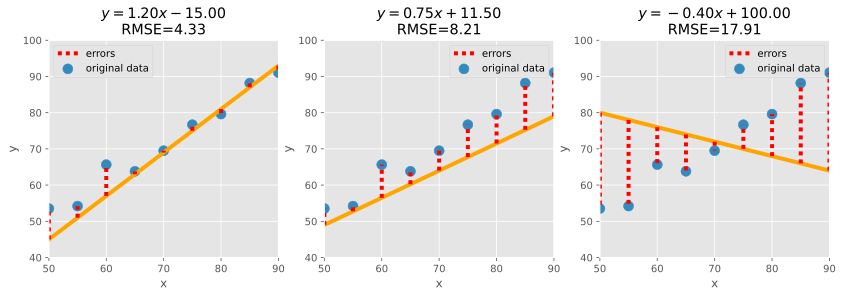

In [32]:
# Experiment by changing one of these!
lines = [(1.2, -15), (0.75, 11.5), (-0.4, 100)]

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for i, line in enumerate(lines):
    plt.subplot(1, 3, i + 1)
    m, b = line
    plot_errors(without_outlier, m, b, ax=ax[i])
    ax[i].set_title(format_equation(m, b) + f'\nRMSE={np.round(rmse(m, b), 2)}')

### Finding the "best" prediction line by minimizing RMSE

- RMSE describes how well a line fits the data. **The lower the RMSE of a line is, the better it fits the data**.

- There are infinitely many slopes and intercepts, and thus infinitely many RMSEs. How do we find which combination of slope and intercept have the lowest RMSE?

- If you take DSC 40A, you'll learn how to do this using calculus. For now, we'll use a function – `minimize`. 

### Aside: `minimize`

- The function `minimize` takes in a function as an argument, and returns the inputs to the function that produce the smallest output. 

- For instance, we know that the minimizing input to the function $f(x) = (x - 5)^2 + 4$ is $x = 5$. `minimize` can find this, too:

In [33]:
def f(x):
    return (x - 5) ** 2 + 4

In [34]:
minimize(f)

array([5.])

- The `minimize` function uses calculus and intelligent trial-and-error to find these inputs; you don't need to know how it works under the hood.

### Finding the "best" prediction line by minimizing RMSE

We'll use `minimize` on `rmse`, to find the slope and intercept of the line with the smallest RMSE.

In [35]:
smallest_rmse_line = minimize(rmse)
smallest_rmse_line

array([0.98, 3.04])

In [36]:
m_smallest_rmse = smallest_rmse_line[0]
b_smallest_rmse = smallest_rmse_line[1]

Do these numbers look familiar?

### Coincidence?

In [37]:
# The slope and intercept with the smallest RMSE, from our call to minimize.
m_smallest_rmse, b_smallest_rmse

(0.9759274388041896, 3.0423565872406115)

In [38]:
# The slope and intercept according to our regression line formulas.
slope(without_outlier, 'x', 'y'), intercept(without_outlier, 'x', 'y')

(0.975927715724588, 3.042337135297444)

The slopes and intercepts we got using both approaches look awfully similar... 👀

### The regression line is the best line!

- It turns out that the regression line we defined before before minimizes the root mean squared error (RMSE) among all lines.

$$m = r \cdot \frac{\text{SD of } y}{\text{SD of }x}$$

$$b = \text{mean of } y - m \cdot \text{mean of } x$$

- It is the **best** line, regardless of what our data looks like!

- All equivalent names:
    - Line of “best fit”.
    - Least squares line.
    - Regression line.

- The technique of finding the slope and intercept that have the lowest RMSE is called the **method of least squares**.

### Quality of fit

- The regression line describes the "best linear fit" for a given dataset.
- The formulas for the slope and intercept work no matter what the shape of the data is.
- But the line is only meaningful if the relationship between $x$ and $y$ is roughly linear.

### Example: Non-linear data

What's the regression line for this dataset?

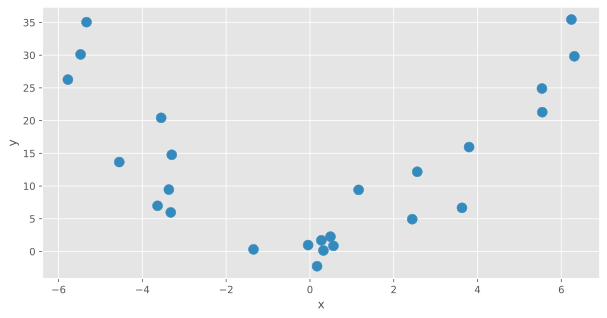

In [39]:
np.random.seed(23)
x2 = bpd.DataFrame().assign(
    x=np.arange(-6, 6.1, 0.5) + np.random.normal(size=25), 
    y=np.arange(-6, 6.1, 0.5)**2 + np.random.normal(size=25)
)
x2.plot(kind='scatter', x='x', y='y', s=100, figsize=(10, 5));

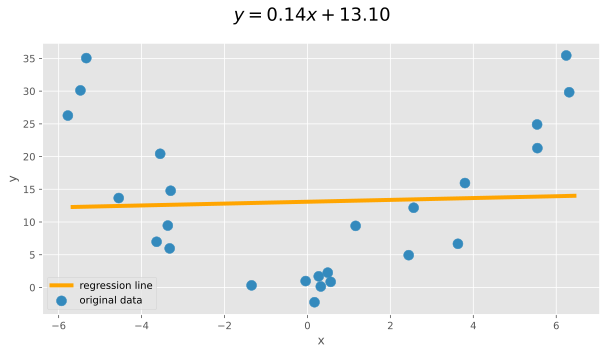

In [40]:
plot_regression_line(x2, 'x', 'y')

This line doesn't fit the data at all!

### Summary, next time

### Summary

- The regression line in original units is $\text{predicted } y = mx + b$, where

$$m = r \cdot \frac{\text{SD of } y}{\text{SD of }x}$$

$$b = \text{mean of } y - m \cdot \text{mean of } x$$
- This line is very sensitive to outliers.
- This line has the lowest root mean squared error (RMSE) of all possible lines.
    - It is the "line of best fit".

### Next time

- As we saw, the regression line is the best *line* to fit the data, but not all data is linear. 
- How do we determine whether fitting a line even makes sense for our dataset?
- When we use regression, we're making predictions based on data in a sample. What if we had a different sample?
